In [18]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import levene

In [19]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [20]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 0
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [21]:
def red_data_err(data,model,res,x0,y0,x_m,y_m,muse_sampling_size,box_size=4):
    if muse_sampling_size == 0.4:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        mod_red = model[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        residual_red = res[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        (x0,y0)=(x0-7,y0-7)
    else:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        mod_red =model[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        residual_red =res[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        (x0,y0)=(x0-14,y0-14)
    #plt.imshow(data_red,origin='lower')
    #plt.show()
    err_red = (data_red - mod_red)/residual_red
    return data_red,mod_red,residual_red,err_red,x0,y0 

In [22]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    new_k = 1+ (vel_OIII_fit/300000)
    select = (wo_wave>4750*new_k) & (wo_wave < 5090*new_k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    print (levene(data[select],fit))
    residual = data[select] - fit

    plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(14, 11)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)

   
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=21)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':',label='BLR')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.set_xlim(4750,5090)
    ax1.set_ylim(0,3.5)
    ax1.annotate(r'H$\beta$',xy=(4861.33,0.8),xytext=(4826.33,2.2),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate(r'[OIII] 4959,5007',xy=(4959,1.0),xytext=(4929,3.0),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate(r'',xy=(5000,2.5),xytext=(4975,3.0),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    #ax1.legend(fontsize=17)
    ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
    ax1.set_title("Spectrum of HE 0040-1105 (z=0.041)",fontsize=21)

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=21)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='r', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.5, color='darkgray')
    ax2.set_xlim(4750,5090)
    ax2.set_ylim(-8,8)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    


In [23]:
def algorithm_script(obj,p_init,z,broad2,asymmetry,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/fitting/full/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    muse_sampling_size = sampling_size(cont_cube)
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube.fits'%(destination_path_cube,obj,obj))
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    #print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    #print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    
    #(y_m,x_m) = (Hb_y,Hb_x)
    
    #overlay_plot(obj,wo_wave,data,error,z,popt_full_fit,muse_sampling_size,broad2,asymmetry)

HE0040-1105


/home/mainak/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mainak/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mainak/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


LeveneResult(statistic=0.0013868602303809582, pvalue=0.9703063661120958)


No handles with labels found to put in legend.
/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


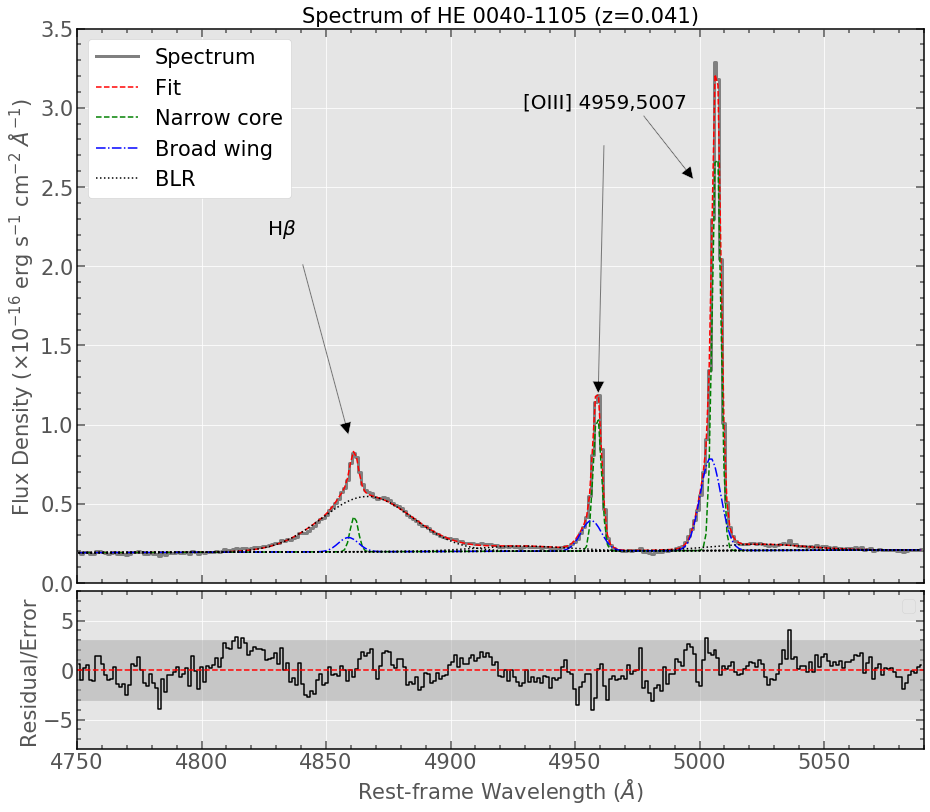

In [24]:
z = {"HE0040-1105":0.041692}

objs = z.keys()

broad2= {'HE0040-1105':False}
asymmetry= {'HE0040-1105':False}


p_init= {'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,200.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj],asymmetry[obj]) 


In [ ]:
def overlay_plot(obj,wo_wave,data,error,z,popt_full_fit,muse_sampling_size,broad2=False,asymmetry=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    (Hb_x,Hb_y,OIII_br_x,OIII_br_y,OIII_nr_x,OIII_nr_y) = moffat_centers(obj)  

    (Hb_data,Hb_model,blr_res,OIII_br_data,OIII_br_model,wing_res,OIII_nr_data,OIII_nr_model,core_res) = loadplot('%s/%s/9_arcsec_maps_flux_mod_%s.fits'%(destination_path_cube,obj,obj))
    half_box_shape = int((Hb_data.shape[0] - 1)/2)
    (y_m,x_m) = (half_box_shape,half_box_shape)
    (Hb_data,Hb_model,Hb_res,Hb_err,Hb_x,Hb_y) = red_data_err(Hb_data,Hb_model,blr_res,Hb_x,Hb_y,x_m,y_m,muse_sampling_size,box_size=4)
    (OIII_br_data,OIII_br_model,OIII_br_res,OIII_br_err,OIII_br_x,OIII_br_y) = red_data_err(OIII_br_data,OIII_br_model,wing_res,OIII_br_x,OIII_br_y,x_m,y_m,muse_sampling_size,box_size=4)
    (OIII_nr_data,OIII_nr_model,OIII_nr_res,OIII_nr_err,OIII_nr_x,OIII_nr_y) = red_data_err(OIII_nr_data,OIII_nr_model,core_res,OIII_nr_x,OIII_nr_y,x_m,y_m,muse_sampling_size,box_size=4)
    (x_min,x_max,y_min,y_max) = ranges_talk(Hb_x,Hb_y,muse_sampling_size,asymmetry)
    cmap = sns.cubehelix_palette(20, light=0.95,dark=0.15, as_cmap=True)

    new_k = 1+ (vel_OIII_fit/300000)
    select = (wo_wave>4750*new_k) & (wo_wave < 5090*new_k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit

    plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(11, 6)) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.06,0.1,0.67,0.87])
    ax2 = fig.add_axes([0.12,0.51,0.358,0.358])
    ax3 = fig.add_axes([0.72,0.10,0.358,0.358])
    ax4 = fig.add_axes([0.72,0.61,0.358,0.358])

    plt.setp(ax1.get_xticklabels(), visible=False)

   
    ax1.xaxis.set_ticks_position('bottom') 
    ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=12)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    #ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':',label='BLR')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.annotate(r'',xy=(4840.33,1.4),xytext=(4850.33,0.6),arrowprops=dict(arrowstyle= '->',color='black',lw=1.2,connectionstyle='arc'),fontsize=20)
    ax1.annotate(r'',xy=(5090,3.0),xytext=(5007,2.5),arrowprops=dict(arrowstyle= '->',color='black',lw=1.2,connectionstyle='angle3'),fontsize=20)
    ax1.annotate(r'',xy=(5090,0.8),xytext=(4998.2,0.3),arrowprops=dict(arrowstyle= '->',color='black',lw=1.2,connectionstyle='angle3'),fontsize=20)
    #ax1.annotate(r'BLR H$\beta$',xy=(4881.33,24.0),xytext=(4900.33,26.0),fontsize=20)    
    ax1.set_xlim(4750,5090)
    ax1.set_ylim(0,3.5)

### here different axes are defined with coordinates [x_start,y_start,x_width,y_width] using relative coordinates from 0 to 1 scaling with the dimension of the figure size

## you can now plot everything you want in different axes. All commands you are used to work now on the axes if you use the corresponding instance.
 
    #plt.setp(ax1.get_xticklabels(), visible=False)

    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=16)
    ax1.set_xlabel(r"Observed Wavelength ($\AA$)",fontsize=16)
    #fig1.savefig('%s/Spectrum/%s_central_spectrum_lightprofile.png'%(destination_path_cube,obj),dpi = 600,overwrite=True)
    #plt.show()
    
    #fig2 = plt.figure(figsize=(3, 3)) 
    ax2.grid(False)
   # ax2.set_xticks([])
   # ax2.set_yticks([])
    Hb_data[Hb_data<0]=0.000001
    amp_blr =  np.max(Hb_data)
    norm_Hb_data = Hb_data/amp_blr
    ax2.imshow(norm_Hb_data,origin='lower',norm=LogNorm(),extent = [x_min,x_max,y_min,y_max],cmap=cmap,vmin=0.01,vmax=1)
    ax2.set_xlabel(r'$\Delta$ x (")',fontsize=16)
    ax2.set_ylabel(r'$\Delta$ y (")',fontsize=16)           
    ax2.text(-1.5,1.45,r'BLR H$\beta$',color='black',fontsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    #ax2.set_title('Hb',color='white')
    #fig2.savefig('%s/Spectrum/%s_BLR.png'%(destination_path_cube,obj),dpi = 600,overwrite=True)

    #fig3 = plt.figure(figsize=(3, 3)) 
    ax3.grid(False)
    #ax3.set_xticks([])
    #ax3.set_yticks([])
    OIII_br_data[OIII_br_data<0]=0.000001
    amp_wing =  np.max(OIII_br_data)
    norm_OIII_br_data =OIII_br_data/amp_wing
    ax3.imshow(norm_OIII_br_data,origin='lower',norm=LogNorm(),extent = [x_min,x_max,y_min,y_max],cmap=cmap,vmin=0.01,vmax=1)
    ax3.set_xlabel(r'$\Delta$ x (")',fontsize=16)
    ax3.set_ylabel(r'$\Delta$ y (")' ,fontsize=16)          
    ax3.text(-1.5,1.45,r'[OIII] wing',color='black',fontsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=12)
    #fig3.savefig('%s/Spectrum/%s_wing.png'%(destination_path_cube,obj),dpi = 600,overwrite=True)

    #fig4 = plt.figure(figsize=(3, 3)) 
    ax4.grid(False)
    #ax4.set_xticks([])
    #ax4.set_yticks([])
    OIII_nr_data[OIII_nr_data<0]=0.000001
    amp_core = np.max(OIII_nr_data)
    norm_OIII_nr_data = OIII_nr_data/amp_core
    ax4.imshow(norm_OIII_nr_data,origin='lower',norm=LogNorm(),extent = [x_min,x_max,y_min,y_max],cmap=cmap,vmin=0.01,vmax=1)
    ax4.set_xlabel(r'$\Delta$ x (")',fontsize=16)
    ax4.set_ylabel(r'$\Delta$ y (")',fontsize=16)           
    ax4.text(-1.5,1.45,r'[OIII] core',color='black',fontsize=14)
    ax4.tick_params(axis='both', which='major', labelsize=12)
    #plt.show()
    #fig4.savefig('%s/Spectrum/%s_core.png'%(destination_path_cube,obj),dpi = 600,overwrite=True)

    #plt.show()     
    fig.savefig('%s/%s_overlay_spectroastrometry.png'%(destination_path_cube,obj),overwrite=True)



In [73]:
a = 43.8359
b = 45.1638
10**(a-b)

0.04700023181798014